## Code to geerate some toy data to test for selection effects

The aim of this code is to generate radio luminosities ffrom the luminosity function of SF galaxies and then generate LIR according to some known model of the FIRC. I can then apply some selection effects to this simulated data to see the effect it has on my results.

In [183]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,lognorm
import scipy.integrate as integrate
from scipy.stats import norm
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from numpy.random import normal

from astropy.table import Table,Column
from lifelines import KaplanMeierFitter
import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm

In [2]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [3]:
def agn_luminosity_function(L):
    #returns N for the luminsity function from Heckman and Best 2014 page 615
    A = 10**(-5.33)
    P0 = 10**24.95
    alpha = 0.42
    beta = 1.66
    
    N = A/((L/P0)**alpha + (L/P0)**beta)
    return(N)

In [4]:
def sf_luminosity_function(L):
    #returns the luminosity function from Mauch and Sadler 2007
    C = 10**(-2.83)
    P0 = 10**(21.18)
    sig = 0.6
    alpha = 1.02
    
    N = C*(L/P0)**(1-alpha) * np.exp(-0.5*((np.log10(1+L/P0)/sig)**2))
    return(N)

In [5]:
def mcmc_sample_from_pdf(func,N,xmin,xmax,ymin,ymax):
    x = []
    for n in range(N):
        x.append(random.random())
    x = np.array(x)
    x = x+xmin + (x*(xmax-xmin))

    y = []
    for n in range(N):
        y.append(random.random())
    y = np.array(y)
    y = y+ymin + (y*(ymax-ymin))
    
    test = func(10**x)
    mask = y<np.log10(test)
    
    return(x[mask])

In [121]:
def generate_q(n,width,dist_type='norm'):
    if dist_type=='norm':
        scatter = norm.rvs(width,size=n)
    if dist_type=='lognorm':
        #good width is 0.4
        scatter = -lognorm.rvs(width,size=n)
        bins = np.arange(-4,4,0.1)
        nums,_ = np.histogram(scatter,bins=bins)
        mode = bins[np.argmax(nums)]
        scatter = scatter - mode+0.05
    
    return(scatter)

In [86]:
def LIR_from_radio(lradio,dist_type='norm'):
    q = 2 + generate_q(len(lradio),dist_type=dist_type)
    
    logLIR = q + np.log10(lradio) + np.log10(3.75E12)
    LIR = 10**logLIR
    
    return(LIR)

In [106]:
def assign_redshift(n):
    #This function assigns each of my galaxies a redshift where the redshifts are drawn 
    #from the redshift distribution of my mass complete sample
    
    lofar_table = Table.read('data/lofar_sed_en1.fits')
    mass_complete_mask = (lofar_table['Z_BEST']<1.0) & (lofar_table['Mass_median']>10.7)
    redshifts = lofar_table[mass_complete_mask]['Z_BEST']
    
    bins = np.arange(0,1,0.01)
    centers = get_center(bins)
    nums,_ = np.histogram(redshifts,bins=bins)
    plt.hist(redshifts,bins=bins)
    plt.show()
    
    y = np.cumsum(nums)
    
    #do MCMC sampling to get redshifts from the distribution
    x = []
    for m in range(n):
        x.append(random.random())
    z = np.interp(x,y/np.max(y),centers)
    
    return(z)
        
    

In [117]:
def calc_Q(l_fir,l_rad):
    Q = np.log10(l_fir/3.75E12) - np.log10(l_rad)
    return(Q)

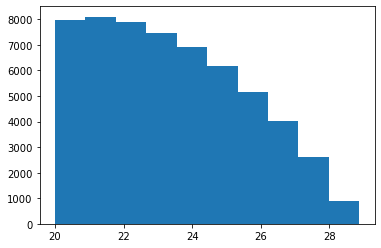

(array([1.1000e+01, 4.2200e+02, 6.1240e+03, 1.1354e+04, 1.0897e+04,
        9.7980e+03, 8.3720e+03, 6.1020e+03, 3.4250e+03, 6.9500e+02]),
 array([31.4046232 , 32.65771651, 33.91080982, 35.16390313, 36.41699644,
        37.67008975, 38.92318306, 40.17627637, 41.42936968, 42.68246299,
        43.9355563 ]),
 <a list of 10 Patch objects>)

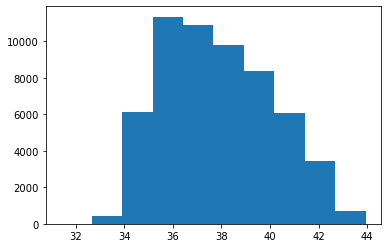

In [90]:
plt.hist(np.log10(sf_lum))
plt.show()
LIR = LIR_from_radio(sf_lum,dist_type='lognorm')

plt.hist(np.log10(LIR))

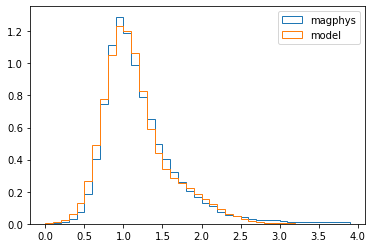

In [161]:
#lofar_table = Table.read('data/lofar_sed_en1.fits')
q = -lofar_table['q_magphys']+2.7
bins=np.arange(0,4,0.1)
plt.hist(q,bins=bins,histtype='step',density=True,label='magphys')

y = lognorm.rvs(0.3,size=100000)
bins = np.arange(0,4,0.1)

nums,_ = np.histogram(y,bins=bins)
#plt.hist(y,bins=bins,histtype='step',density=True)

y1 = norm.rvs(0.98,0.24,size=65000)
bins = np.arange(0,4,0.1)
y2 = norm.rvs(1.5,0.5,size=35000)
bins = np.arange(0,4,0.1)
y = np.append(y1,y2)

nums,_ = np.histogram(y,bins=bins)
plt.hist(y,bins=bins,histtype='step',density=True,label='model')

plt.legend()
plt.show()

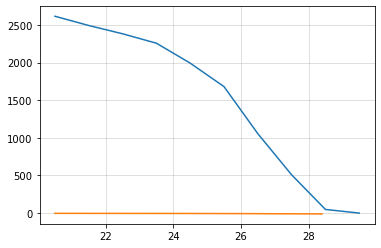

NameError: name 'gurkan_calc_l250_agn' is not defined

In [6]:
agn_lum = 10**mcmc_sample_from_pdf(agn_luminosity_function,30000,20,30,np.log10(agn_luminosity_function(1E20)),np.log10(agn_luminosity_function(1E29)))

bins = np.arange(20,30.1,1)
x = get_center(bins)
y,_ = np.histogram(np.log10(agn_lum),bins=bins)
plt.plot(x,y)

x = np.arange(20.5,28.5,0.1)
y = agn_luminosity_function(10**x)
plt.plot(x,np.log10(y))
plt.grid(alpha=0.5)
plt.show()

agn_lum_fir = gurkan_calc_l250_agn(agn_lum)
y = np.log10(agn_lum_fir) #- np.log10(3E26)
bins=np.arange(-10,40,0.5)
plt.hist(y,bins=bins,log=True)
plt.show()

plt.scatter(np.log10(agn_lum_fir),np.log10(agn_lum),s=1)
x = np.arange(20,28,0.01)
#to estimate an agn FIRC relation i increases the normalistaion by 2 and increased the scatter by 0.5
y = gurkan_fit(10**x,1.65,-3.05)
plt.plot(np.log10(y),x,c='black')
#Q = calc_Q(sf_lum_fir,sf_lum)
#plt.hist(Q,bins=np.arange(-20,20,0.1),log=True)
plt.show()

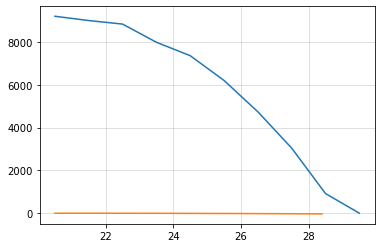

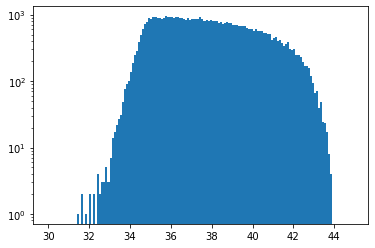

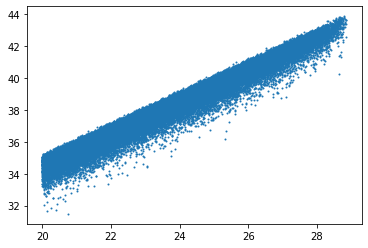

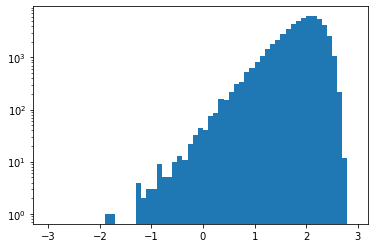

In [120]:
sf_lum = 10**mcmc_sample_from_pdf(sf_luminosity_function,100000,20,30,np.log10(sf_luminosity_function(1E20)),np.log10(sf_luminosity_function(1E29)))

bins = np.arange(20,30.1,1)
x = get_center(bins)
y,_ = np.histogram(np.log10(sf_lum),bins=bins)
plt.plot(x,y)

x = np.arange(20.5,28.5,0.1)
y = sf_luminosity_function(10**x)
plt.plot(x,np.log10(y))
plt.grid(alpha=0.5)
plt.show()

sf_lum_fir = LIR_from_radio(sf_lum,dist_type='lognorm')
y = np.log10(sf_lum_fir) #- np.log10(3E26)
bins=np.arange(30,45,0.1)
plt.hist(y,bins=bins,log=True)
plt.show()

plt.scatter(np.log10(sf_lum),np.log10(sf_lum_fir),s=1)
plt.show()
x = np.arange(20,28,0.01)
#y = gurkan_fit(10**x,1.15,-5.05)
#plt.plot(np.log10(y),x,c='black')
Q = calc_Q(sf_lum_fir,sf_lum)
plt.hist(Q,bins=np.arange(-3,3,0.1),log=True)
plt.show()

In [169]:
np.median(Q)

1.9511976663968102

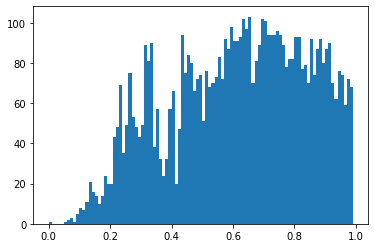

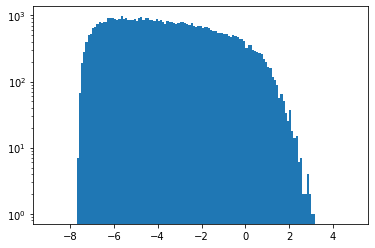

In [168]:
#assign redshifts to the sources and calculate their radio flux

redshifts = assign_redshift(len(sf_lum))
alpha = -0.7

dist = cosmo.luminosity_distance(redshifts).to(u.m).value
radio_flux = sf_lum/(4*np.pi*dist**2 * (1+redshifts)**(-1-alpha))

y = np.log10(radio_flux*1E26)
plt.hist(y,bins=np.arange(-9,5,0.1),log=True)
plt.show()

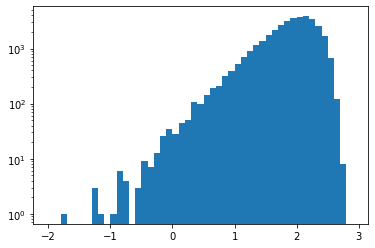

1.949697283536434

In [172]:
#apply some selection effects on the observed fluxes

mask_selection = radio_flux*1E26>2E-5

bins = np.arange(-2,3,0.1)
y = Q[mask_selection]
plt.hist(y,bins=bins,log=True)
plt.show()
np.median(y)

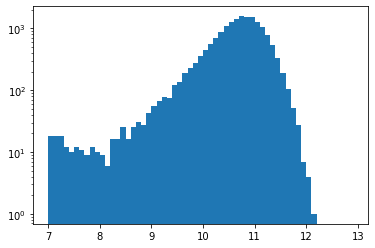

In [235]:
y = lofar_table['Mass_median']
bins = np.arange(7,13,0.1)
plt.hist(y,bins=bins,log=True)
plt.show()

In [184]:
bethermin_sim = Table.read('../../simulations/bethermin/Mock_cat_Bethermin2017.fits')
bethermin_table = Table()
for n,name in enumerate(bethermin_sim.colnames):
    col = Column(data=bethermin_sim[name][0],name=name)
    bethermin_table.add_column(col)
bethermin_table[0]

REDSHIFT,RA,DEC,MHALO,MSTAR,QFLAG,SFR,MU,ISSB,UMEAN,SMIPS24,SPACS70,SPACS100,SPACS160,SSPIRE250,SSPIRE350,SSPIRE500,SNIKA1200,SNIKA2000,S200,S450,S750,S850,S1100,S1300,SSPIRE250EXT,SSPIRE350EXT,SSPIRE500EXT
float64,float64,float64,float64,float64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0.027082,1.386314,0.578664,975516200000.0,11660010000.0,1,0.0,0.9906432,0.0,4.0340633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


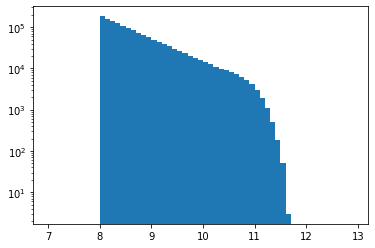

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


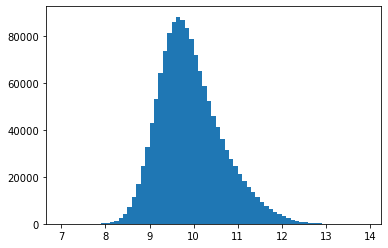

In [233]:
bins = np.arange(7,13,0.1)
plt.hist(np.log10(bethermin_table['MSTAR']),bins=bins,log=True)
plt.show()

bins = np.arange(7,14,0.1)
y = np.log10(bethermin_table['SFR'] / 1E-10)
plt.hist(y,bins=bins)
plt.show()

In [224]:
#mask = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)
lir = bethermin_table['SFR'] / 1E-10 * 3.8E26
q = generate_q(len(lir),0.4,dist_type='lognorm')
lrad = 10**(np.log10(lir/3.75E12) - q)

alpha = -0.73
z = bethermin_table['REDSHIFT']
dist = cosmo.luminosity_distance(z).to(u.m).value
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-alpha)) * 1E26 #get radio fluxes in Jy

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


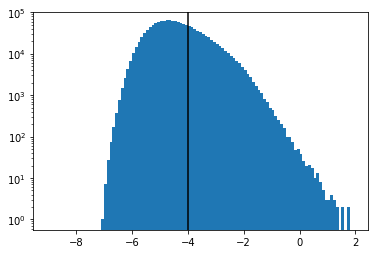

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


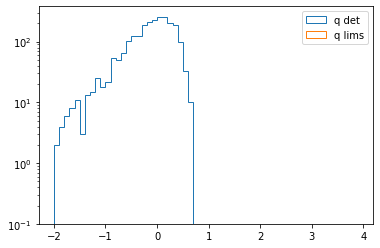

my selection median is:-0.0522258466632806
Calistro selection median is:-0.3750094063729939


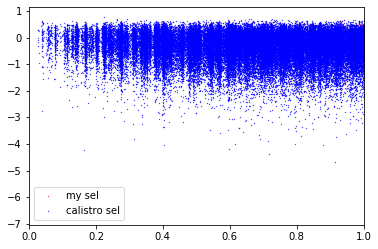

In [237]:
bins = np.arange(-9,2,0.1)
y = np.log10(frad)
plt.hist(y,bins=bins,log=True)
plt.vlines(-4,0,1E5)
plt.ylim(0,1E5)
plt.show()

mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)
mask_rad_sel = (frad>1E-4)  

bins = np.arange(-2,4,0.1)
q_det = q[mask_rad_sel & mask_mass]
plt.hist(q_det,bins=bins,log=True,histtype='step',label='q det')

frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel & mask_mass]**2 * (1+z[~mask_rad_sel & mask_mass])**(-1-alpha))
q_lim = np.log10(lir[~mask_rad_sel & mask_mass]/3.75E12) - np.log10(lrad_lim)
plt.hist(q_lim,bins=bins,log=True,histtype='step',label='q lims')
plt.legend()
plt.show()

x = z[mask_mass & mask_rad_sel]
y = q_det
print('my selection median is:{}'.format(np.median(y)))
plt.scatter(x,y,s=0.1,c='red',label='my sel')

mask_calistro = (frad>6E-4)
q_det = q[mask_calistro]
x = z[mask_calistro]
y = q_det
print('Calistro selection median is:{}'.format(np.median(y)))
plt.scatter(x,y,s=0.1,c='blue',label='calistro sel')

plt.xlim(0,1)
plt.legend()
plt.show()
